# Show, Attend and Tell: Neural Image Caption Generation with Visual Attention

[Xu et al. 2015](https://arxiv.org/abs/1502.03044)

In [1]:
from fastai.text import *
from fastai.callbacks import SaveModelCallback, ReduceLROnPlateauCallback, CSVLogger
from pathlib import Path
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import ImageFile
import pdb
from caption_generator_api.utils import *
from caption_generator_api.BeamSearch import *
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
gpu = torch.device('cuda:0')

## Download and prepare data
Download the files `Train_GCC-training.tsv` and `Validation_GCC-1.1.0-Validation.tsv` from [here](https://ai.google.com/research/ConceptualCaptions). The files contain URL-Image caption pairs. The scripts `download_images.py` and `download_dataset.sh` help you download the images (install GNU parallel).

1. Put the files `Train_GCC-training.tsv` and `Validation_GCC-1.1.0-Validation.tsv` in separate folders and copy the download scripts in both of them.
2. Run `./download_dataset.sh Train_GCC-training.tsv 200` (and same for validation dataset). Here, the 200 depicts the number of pixels for the smaller side of the images. I recommend 200 but feel free to download them in any other size. The train dataset contains more than 3 million images that take quite a long time to download depending on your internet connection and number of CPU cores. The full dataset requires ~300GB of storage but you can download a subset of the dataset and still get very good results. In order to do so, change line 3 in `download_dataset.sh` i.e. to NUM_LINES=500000.

*Alternatively you could download the COCO dataset which provides image-caption pairs as well. The google dataset is more exciting, however, because it contains real world data as opposed to COOCO which is very academic and cured.*

### MS COCO
Download A. Karpathy's [train-validation-test-split](http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip)

In [3]:
PATH = Path('ms_coco_data/')
PATH.mkdir(exist_ok=True)

VALID_PATH = PATH/"valid"
VALID_PATH.mkdir(exist_ok=True)

TRAIN_PATH= PATH/"train"
TRAIN_PATH.mkdir(exist_ok=True)

In [4]:
dataset_json = json.load((PATH/'dataset_coco.json').open())

In [5]:
len(dataset_json["images"])

123287

In [6]:
train = [d for d in dataset_json["images"] if d["split"] in {"train", "restval"}]
test  = [d for d in dataset_json["images"] if d["split"] == "test"]
valid = [d for d in dataset_json["images"] if d["split"] == "val"]

In [7]:
train_fns_caps = [(d["filepath"]+"/"+d["filename"], [c["raw"] for c in d["sentences"]]) for d in train]
test_fns_caps  = [(d["filepath"]+"/"+d["filename"], [c["raw"] for c in d["sentences"]]) for d in test]
valid_fns_caps = [(d["filepath"]+"/"+d["filename"], [c["raw"] for c in d["sentences"]]) for d in valid]

These lists contain tuples of filenames and a list of corresponding captions.

In [8]:
train_fns_caps[0]

('val2014/COCO_val2014_000000522418.jpg',
 ['A woman wearing a net on her head cutting a cake. ',
  'A woman cutting a large white sheet cake.',
  'A woman wearing a hair net cutting a large sheet cake.',
  'there is a woman that is cutting a white cake',
  "A woman marking a cake with the back of a chef's knife. "])

#### Let's tokenize the captions and create our vocabulary

In [ ]:
tokenizer = Tokenizer(n_cpus=1)

In [ ]:
train_captions_tokenized = tokenizer.process_all(
    list(itertools.chain.from_iterable(list(zip(*train_fns_caps))[1]))
)

In [ ]:
vocab = Vocab.create(train_captions_tokenized, max_vocab=50000, min_freq=2)

In [ ]:
pickle.dump(vocab, open(PATH/"vocab.pkl", 'wb'))

In [4]:
vocab = pickle.load((PATH/"vocab.pkl").open('rb'))

In [5]:
len(vocab.itos)

16075

In [ ]:
def numericalize_tokens(tok):
    return np.array([vocab.numericalize(q) + [1] for q in tok])

In [ ]:
def build_data(fns_caps, PATH, name):
    filenames, captions = zip(*fns_caps)
    filenames = list(map(lambda x: str(PATH) +"/" + x,filenames))
    captions_tok = list()
    for c in captions:
        captions_tok.append(numericalize_tokens(tokenizer.process_all(c)))
    dataset = (filenames, captions_tok)
    pickle.dump(dataset, open(str(PATH)+"/"+name+".pkl", 'wb'))

In [ ]:
%time build_data(train_fns_caps, PATH, "train")

In [ ]:
%time build_data(test_fns_caps, PATH, "test")

In [ ]:
%time build_data(valid_fns_caps, PATH, "valid")

In [5]:
valid_data = pickle.load((PATH/"valid.pkl").open('rb'))
test_data  = pickle.load((PATH/"test.pkl").open('rb'))
train_data = pickle.load((PATH/"train.pkl").open('rb'))

### Conceptual Captions

In [3]:
PATH = Path('data/')
PATH.mkdir(exist_ok=True)

VALID_PATH = PATH/"valid"
VALID_PATH.mkdir(exist_ok=True)

TRAIN_PATH= PATH/"train"
TRAIN_PATH.mkdir(exist_ok=True)

The download script creates one dictionary of downloaded image filenames and corresponding captions per CPU core. We need to combine them:

In [ ]:
def show_training_pair(PATH, caption_dict, idx):
    fn, caption = caption_dict[idx]
    img = Image.open(PATH/"downloadedPics"/fn)
    plt.imshow(img)
    print(caption)

In [ ]:
def load_partial_dicts(PATH):
    combined_dict = dict()
    for fn in PATH.iterdir():
        if str(fn)[-3:] == "pkl":
            combined_dict.update(pickle.load(fn.open('rb')))
    pickle.dump(combined_dict, open(PATH/'caption_dict.pkl', 'wb'))

In [ ]:
load_partial_dicts(VALID_PATH)

In [ ]:
valid_dict = pickle.load((VALID_PATH/"caption_dict.pkl").open('rb'))

In [ ]:
load_partial_dicts(TRAIN_PATH)

In [ ]:
train_dict = pickle.load((TRAIN_PATH/"caption_dict.pkl").open('rb'))

**Example from the validation dataset:**

In [ ]:
len(valid_dict)

In [ ]:
show_training_pair(VALID_PATH, valid_dict, 13900)

**Example from the train dataset:**

In [ ]:
len(train_dict)

In [ ]:
show_training_pair(TRAIN_PATH, train_dict, 131900)

In [ ]:
train_dict[12334]

#### Let's tokenize the captions and create our vocabulary

In [ ]:
tokenizer = Tokenizer()

In [ ]:
train_captions_tokenized = tokenizer.process_all(
    list(v[1] for v in train_dict.values())
)

In [ ]:
vocab = Vocab.create(train_captions_tokenized, max_vocab=50000, min_freq=2)

In [ ]:
pickle.dump(vocab, open(PATH/"vocab.pkl", 'wb'))

In [5]:
vocab = pickle.load((PATH/"vocab.pkl").open('rb'))

In [6]:
len(vocab.itos)

32721

In [ ]:
def numericalize_tokens(tok):
    return np.array([vocab.numericalize(q) + [1] for q in tok])

The `[1]` stands for the special 'pad token' used here to represent the end of sentence.

In [ ]:
def build_data(captions_dict, PATH):
    filenames, captions = zip(*list(captions_dict.values()))
    filenames = list(map(lambda x: str(PATH/"downloadedPics") +"/" + x,filenames))
    captions = tokenizer.process_all(captions)
    captions_tok = numericalize_tokens(captions)
    dataset = (filenames, captions_tok)
    pickle.dump(dataset, open(PATH/"dataset.pkl", 'wb'))

In [ ]:
build_data(valid_dict, VALID_PATH)
build_data(train_dict, TRAIN_PATH)

In [7]:
valid_data = pickle.load((VALID_PATH/"dataset.pkl").open('rb'))
train_data = pickle.load((TRAIN_PATH/"dataset.pkl").open('rb'))

In [8]:
valid_data[0][:3]

['data/valid/downloadedPics/5280.png',
 'data/valid/downloadedPics/5281.png',
 'data/valid/downloadedPics/5282.png']

#### Let's create our dataset objects
Custom PyTorch datasets need a `__len__` method returning the length of the dataset and a `__getitem__` method specifying how to access a certain element.

In [6]:
sz = 224

In [7]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
          data (tuple): Contains a list of filenames and a list of tokenized and numericalized captions
          transforms (callable, optional): Optional transforms to be applied
        """
        self.filenames = data[0]
        self.captions  = data[1]
        self.transform = transform
        self.mult_captions_per_image = not isinstance(train_data[1][0][0], int)
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # Grayscale images in dataset have to be onverted as tensor shapes have to match except in dim=0
        image = Image.open(self.filenames[idx]).convert('RGB')
        if self.mult_captions_per_image:
            caption = self.captions[idx][random.randint(0, len(self.captions[idx]) - 1)]
        else:
            caption = self.captions[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return (image, caption)

In [8]:
train_tfms = transforms.Compose([
    #transforms.RandomResizedCrop(sz, scale=(0.2,1.0)),
    #transforms.Resize(sz),
    #transforms.RandomRotation(10, expand=False),
    transforms.CenterCrop(sz),
    #transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718], [0.3159, 0.3091, 0.3216])
])

valid_tfms = transforms.Compose([
    transforms.Resize(sz),
    transforms.CenterCrop(sz),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718], [0.3159, 0.3091, 0.3216])
])

inv_normalize = transforms.Normalize(
    mean=[-0.5238/0.3159, -0.5003/0.3091, -0.4718/0.3216],
    std=[1/0.3159, 1/0.3091, 1/0.3216]
)

# To denormalize images
denorm = transforms.Compose([
    inv_normalize,
    transforms.functional.to_pil_image
])

In [9]:
valid_dataset = ImageCaptionDataset(valid_data, transform=valid_tfms)

In [10]:
train_dataset = ImageCaptionDataset(train_data, transform=train_tfms)

In [11]:
len(valid_dataset)

5000

In [12]:
len(train_dataset)

113287

Quick test:

a chair and a umbrella that is on a beach xxpad


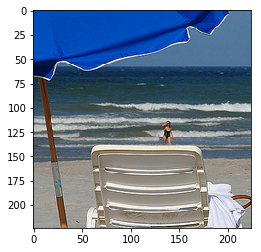

In [14]:
idx = 1084
d = train_dataset
img, cap = d[idx]
print(vocab.textify(cap))
plt.imshow(denorm(img))

#### Let's create our custom DataLoaders

In [15]:
bs = 80

The `pad_collate_ImgCap` function does the following:
A PyTorch DataLoader has the optional argument *collate_fn (callable, optional) – merges a list of samples to form a mini-batch.* Why do we need this? We want to process a large number of images and captions in bulk/at the same time in order to make good use of our GPUs. To do that, both images and captions have to be combined to form two tensors. For the images this is unproblematic, they are simply stacked together. But what happens when the captions don't have the sampe length?

Let's consider the following example:

1. 'dog playing in the grass in summer' -> `[141, 183, 12, 8, 239, 12, 167]`
2. 'cat on sofa' -> `[251, 13, 1035]`

To combine those two captions into a single tensor, we have to *pad* the shorter caption with the special pad token `'xxpad'` or `1`. The resulting tensor then looks like this:
```
tensor([[  251,   141],
        [   13,   183],
        [ 1035,    12],
        [    1,     8],
        [    1,   239],
        [    1,    12],
        [    1,   167],
        [    1,     1]])
```

All captions end with `1` as this also symbolizes *end of sequence* here.

In [16]:
def pad_collate_ImgCap(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    images, captions = zip(*samples)
    max_len_cap = max([len(c) for c in captions])
    
    res_cap = torch.zeros(len(samples), max_len_cap).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,c in enumerate(captions):
        if pad_first: 
            res_cap[i,-len(c):] = LongTensor(c)
        else:         
            res_cap[i,:len(c)] = LongTensor(c)
    
    if backwards:
        cap = cap.flip(1)
    if transpose:
        res_cap.transpose_(0,1)
    
    return (torch.stack(images, 0, out=None), res_cap), res_cap

In [17]:
imgcap_collate_func = partial(pad_collate_ImgCap, pad_first=False, transpose=True)

What do *Samplers* do? 

PyTorch DataLoaders take an optional argument *sampler (Sampler, optional) – defines the strategy to draw samples from the dataset. If specified, shuffle must be False.*

Why do we need this? Take another look at the example caption tensor I showed three cells up. Image having 100 captions of varying length. The length of the tensor will be defined be the longest caption. The shorter captions are padded with 1's. The more padding, the more wasted computations as these tokens contain no information. We want to make sure that the captions that end up in a batch don't contain to much padding. The `SortSampler` returns the indices in a way that the captions are sorted with respect to length (hence the `key=...`). This reduces the need for padding and is perfectly fine for validation as no learning happens. During training, we want a little more randomness as simply feeding the network the captions in sorted order with respect to length is a strong constraint. The `SortishSampler` returns indices for a batch of approximately equally long captions, then indices for a batch of approximately equally short captions, and so on.

In [18]:
val_sampler = SortSampler(valid_data[1], key=lambda x: len(valid_data[1][x]))
trn_sampler = SortishSampler(train_data[1], key=lambda x: len(train_data[1][x]), bs=bs)

In [19]:
val_dl = DataLoader(dataset=valid_dataset, batch_size=bs, sampler=val_sampler, collate_fn=imgcap_collate_func)
trn_dl = DataLoader(dataset=train_dataset, batch_size=bs, sampler=trn_sampler, collate_fn=imgcap_collate_func)

Quick test:

In [20]:
ims, caps = next(iter(trn_dl))

In [21]:
print(ims[0].shape, ims[1].shape, caps.shape)

torch.Size([80, 3, 224, 224]) torch.Size([23, 80]) torch.Size([23, 80])


xxmaj the men are trying to fly their kite by the water . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad


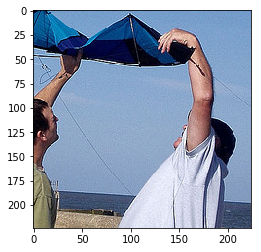

In [22]:
idx = 40
print(vocab.textify(caps[:,idx]))
plt.imshow(denorm(ims[0][idx]))

## Build the architecture

In [23]:
n_layers, emb_sz = 1, 500

In [24]:
def fc_layer(n_in, n_out, p=0.1):
    return nn.Sequential(
        Flatten(),
        nn.Linear(in_features=n_in, out_features=n_out),
        nn.Dropout(p),
    )

In [25]:
class Encoder(nn.Module):
    def __init__(self, device, dec_hidden_state_size, dec_layers, filter_width, num_filters):
        super().__init__()
        # Visual Encoder
        self.device = device
        self.base_network = nn.Sequential(*list(models.resnet101(pretrained=True).children())[:-2])
        self.freeze_base_network()
        self.concatPool = AdaptiveConcatPool2d(sz=1)
        self.adaptivePool = nn.AdaptiveAvgPool2d((filter_width, filter_width))
        self.filter_width = filter_width
        
        self.output_layers = nn.ModuleList([
            fc_layer(2*num_filters, dec_hidden_state_size) for _ in range(dec_layers)
        ])
          
    def forward(self, inp):
        #pdb.set_trace()
        enc_output = self.base_network(inp)
        annotation_vecs = self.adaptivePool(enc_output).view(enc_output.size(0), enc_output.size(1), -1)
        enc_output = self.concatPool(enc_output)
        
        dec_init_hidden_states = [MLP_layer(enc_output) for MLP_layer in self.output_layers]
        
        return torch.stack(dec_init_hidden_states, dim = 0), annotation_vecs.transpose(1, 2)
    
    def freeze_base_network(self):
        for layer in self.base_network:
            requires_grad(layer, False)
            
    def fine_tune(self, from_block=-1):
        for layer in self.base_network[from_block:]:
            requires_grad(layer, True)

In [26]:
class VisualAttention(nn.Module):
    def __init__(self, num_filters, dec_dim, att_dim):
        super().__init__()
        self.attend_annot_vec = nn.Linear(num_filters, att_dim)
        self.attend_dec_hidden= nn.Linear(dec_dim, att_dim)
        self.f_att = nn.Linear(att_dim, 1)  # Equation (4) in Xu et al. (2015)
        
    def forward(self, annotation_vecs, dec_hid_state):
        #pdb.set_trace()
        attended_annotation_vecs = self.attend_annot_vec(annotation_vecs)
        attended_dec_hid_state   = self.attend_dec_hidden(dec_hid_state)
        e = self.f_att(F.relu(attended_annotation_vecs + attended_dec_hid_state.unsqueeze(1))).squeeze(2)  # Eq. 4
        alphas = F.softmax(e, dim=1)  # Equation (5) in Xu et al. (2015)
        context_vec = (annotation_vecs * alphas.unsqueeze(2)).sum(1)  # Equations (13)
        
        return context_vec, alphas

In [27]:
class ImageCaptionGenerator(nn.Module):
    def __init__(self, device, filter_width, num_filters, vocab_size, emb_sz, out_seqlen, n_layers=3, prob_teach_forcing=1, p_drop=0.3):
        super().__init__()
        self.n_layers, self.out_seqlen = n_layers, out_seqlen
        self.filter_width = filter_width
        self.num_filters = num_filters
        self.device = device  
        
        # Encoder
        self.encoder = Encoder(device, emb_sz, n_layers, filter_width, num_filters)
        
        # Attention
        self.att = VisualAttention(num_filters, emb_sz, 500)
        
        # Decoder
        self.emb = nn.Embedding(vocab_size, emb_sz) #create_emb(wordvecs, itos, emb_sz)
        self.rnn_dec = nn.GRU(num_filters + emb_sz, emb_sz, num_layers=n_layers, dropout=0 if n_layers == 1 else p_drop)  # square to enable weight tying
        self.out_drop = nn.Dropout(p_drop)
        self.out = nn.Linear(emb_sz, vocab_size)
        self.out.weight.data = self.emb.weight.data
        self.f_b = nn.Linear(emb_sz, num_filters)  # Section 4.2.1 in Xu et al. (2015)
        
        self.prob_teach_forcing = prob_teach_forcing
        self.initializer()
        
    def initializer(self):
        self.emb.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, x, y=None):
        #pdb.set_trace()
        h, annotation_vecs = self.encode(x)

        dec_inp = torch.zeros(h.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        alphas = []
        
        for i in range(self.out_seqlen):
            #pdb.set_trace()
            dec_output, h, alpha = self.decode_step(dec_inp, h, annotation_vecs)
            res.append(dec_output)
            alphas.append(alpha)
            
            if (dec_inp == 1).all() or (y is not None and i >= len(y)):
                break            
            # teacher forcing
            elif y is not None and (self.prob_teach_forcing > 0) and (random.random() < self.prob_teach_forcing):
                dec_inp = y[i].to(self.device)
            else:
                dec_inp = dec_output.data.max(1)[1]  # [1] to get argmax

        return torch.stack(res), torch.stack(alphas)
    
    def encode(self, x):
        return self.encoder(x.to(self.device))
    
    def decode_step(self, dec_inp, h, annotation_vecs):
        #pdb.set_trace()
        context_vec, alpha = self.att(annotation_vecs, h[-1])
        beta = torch.sigmoid(self.f_b(h[-1]))
        context_vec = beta * context_vec  # Section 4.2.1 in Xu et al. (2015)
        
        emb_inp = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once

        output, h = self.rnn_dec(torch.cat([emb_inp, context_vec.unsqueeze(0)], dim=2), h)
        output = self.out(self.out_drop(output[0]))

        return F.log_softmax(output, dim=1), h, alpha

#### Teacher forcing
In the beginning the caption generator will produce only random sentences. We can kick start training by sometimes "whispering the answer for the next word" to the network.

In [28]:
@dataclass
class TeacherForcingCallback(Callback):
    def __init__(self, learn:Learner, decay_epochs=45):
        super().__init__()
        self.learn = learn
        self.decay_iterations = decay_epochs * len(self.learn.data.train_ds) // self.learn.data.batch_size
    
    def on_batch_begin(self, iteration: int, **kwargs: Any) -> None:
        self.learn.model.prob_teach_forcing = (self.decay_iterations-iteration) * 1/self.decay_iterations if iteration < self.decay_iterations else 0

#### Loss function

In [29]:
def ImageCaptionLoss(pred, target, lamb = 1):
    #pdb.set_trace()
    pred, alphas = pred
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    loss = F.nll_loss(pred.contiguous().view(-1, n_probs), target.contiguous().view(-1))
    
    # See section 4.2.1 "Doubly stocastic attention"
    penalty = ((1. - alphas.sum(0)) ** 2.).mean()
    # ((1. - alphas.sum(0)) ** 2.).sum(1).mean()

    return loss + lamb * penalty

#### Metrics - BLEU score
The `corpus_bleu` function from `nltk.translate` expects the input in the following way:

`references[i]` is a list of lists of tokens (there might be more than one label per training pair, here just one though). `candidates[i]` is a list of tokens (this is our prediction).

```
references = [[[203, 23, 9, 1659], [29, 23, 1659]]]
candidates = [[29, 23, 9, 1650]]
corpus_bleu(references, candidates)
```

In [30]:
from nltk.translate.bleu_score import corpus_bleu

class BleuMetric(Callback):
    def on_epoch_begin(self, **kwargs):
        self.references = list()
        self.candidates = list()
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        #pdb.set_trace()
        num_sentences = last_output[0].size(1)
        cands = last_output[0].data.max(2)[1].transpose(1,0).chunk(num_sentences, 0)
        refs = last_target.transpose(1,0).chunk(num_sentences, 0)
        
        self.candidates.extend([[tok for tok in c[0].cpu().numpy() if tok != 1] for c in cands])
        self.references.extend([[[tok for tok in r[0].cpu().numpy() if tok != 1]] for r in refs])
        
    def on_epoch_end(self, last_metrics, **kwargs):
        #pdb.set_trace()
        assert len(self.references) == len(self.candidates)
        return add_metrics(last_metrics, corpus_bleu(self.references, self.candidates))

In [31]:
imgCapGen = ImageCaptionGenerator(gpu, 7, 2048, len(vocab.itos), emb_sz, 50, n_layers, p_drop=0.2)

In [32]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [33]:
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=PATH, collate_fn=imgcap_collate_func)

In [34]:
learn = Learner(data=dataBunch, model=to_device(imgCapGen, gpu), opt_func=opt_fn, loss_func=ImageCaptionLoss, callback_fns=[ShowGraph], metrics=[BleuMetric()]) # , BnFreeze 

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


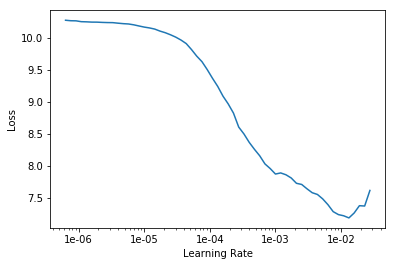

In [36]:
learn.recorder.plot(skip_end=5)

In [38]:
lr = 4e-4

epoch,train_loss,valid_loss,bleu_metric,time
0,3.657221,4.600094,0.050708,5:46:02
1,3.365525,4.334349,0.063685,5:42:07
2,3.334257,4.221170,0.071456,5:43:34
3,3.243235,4.167965,0.076998,5:47:39
4,3.212189,4.156365,0.078641,5:53:50


/home/fabiograetz/anaconda3/envs/imgcap/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


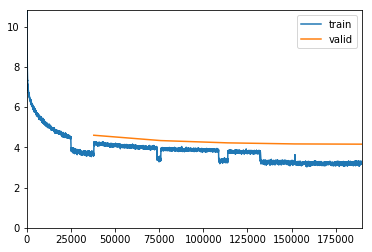

Better model found at epoch 0 with bleu_metric value: 0.0507080250428276.
Better model found at epoch 1 with bleu_metric value: 0.06368528664091778.
Better model found at epoch 2 with bleu_metric value: 0.07145572651955177.
Better model found at epoch 3 with bleu_metric value: 0.076997919441828.
Better model found at epoch 4 with bleu_metric value: 0.07864130472424886.


In [39]:
learn.fit_one_cycle(5, lr, callbacks=[
    SaveModelCallback(learn, monitor='bleu_metric'),
    CSVLogger(learn, filename='train_img_cap_gen')
                                     ])

In [40]:
lr = 1e-4

epoch,train_loss,valid_loss,bleu_metric,time
0,1.509190,1.502689,0.142836,23:44
1,1.522950,1.578547,0.147722,23:42
2,1.614483,1.471989,0.146517,23:47
3,1.487491,1.477702,0.149197,23:48
4,1.527557,1.509952,0.147049,23:47
5,1.557777,1.459065,0.145001,23:43
6,1.512247,1.470219,0.146524,23:48
7,1.528837,1.465798,0.150395,23:48
8,1.592813,1.516387,0.150857,23:46
9,1.541398,1.494485,0.146942,23:42


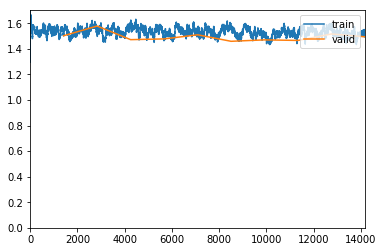

Better model found at epoch 0 with bleu_metric value: 0.14283579973519372.
Better model found at epoch 1 with bleu_metric value: 0.14772230553636714.
Better model found at epoch 3 with bleu_metric value: 0.14919714912391258.
Better model found at epoch 7 with bleu_metric value: 0.15039485942590325.
Better model found at epoch 8 with bleu_metric value: 0.1508569796887353.


In [43]:
learn.fit_one_cycle(10, lr, callbacks=[
    SaveModelCallback(learn, monitor='bleu_metric'),
    CSVLogger(learn, filename='train_img_cap_gen')
                                     ])

If you want to fine tune the last layers of the base network:

In [39]:
learn.model.encoder.fine_tune(-1)

In [ ]:
for l in list(learn.model.encoder.children())[0]:
    print(l, requires_grad(l))

## Test using Beam Search against all reference captions

In [38]:
learn.load("bestmodel_ms_coco");

In [39]:
learn.model.eval();

In [ ]:
data = test_data
beam_width = 5

In [ ]:
beam_search = BeamSearch(learn.model.encode, learn.model.decode_step, beam_width)
preds = list()
references = list()

for i, (im, ref_caps) in enumerate(zip(*data)):
    im = valid_tfms(Image.open(im).convert('RGB'))
    pred, _ = beam_search(im)
    
    preds.append(pred)
    references.append([r for r in ref_caps])
    
    if i % 500 == 0:
        print('{0}/{1}'.format(i, len(data[0])))

print('Total Bleu score for a beam width of {0}: {score}'.format(beam_width, score=100 * corpus_bleu(references, preds)))

## Viszualize attention

In [40]:
beam_width = 5

In [41]:
beam_search = BeamSearch(learn.model.encode, learn.model.decode_step, beam_width)

a man standing on a beach holding a surfboard .


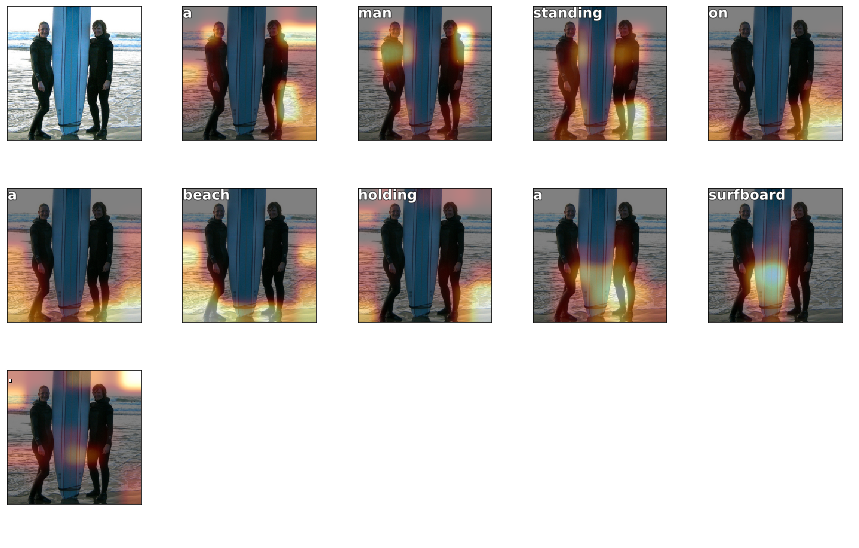

In [45]:
im = learn.data.valid_ds[random.randint(0, 5000)][0]
results = beam_search(im)
print(vocab.textify(results[0]))
visualize_attention(im, results[0], results[1], denorm, vocab, att_size=7, sz=sz, thresh=0.02)

### Export model for deployment

In [67]:
torch.save(learn.model, 'model_conceptual_captions.pth')